In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from cnp.data import GPGenerator

from cnp.cnp import StandardGNP, StandardAGNP, StandardConvGNP, FullConvGNP
from cnp.cov import InnerProdCov, KvvCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno
from shutil import copyfile

from collections import OrderedDict

from itertools import product

import matplotlib
# matplotlib.rcParams['text.usetex'] = True

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

In [2]:
def eq_cov(lengthscale, coefficient, noise):
    
    def _eq_cov(x, x_, use_noise):
    
        diff = x[:, None, :] - x_[None, :, :]
        l2 = torch.sum((diff / lengthscale) ** 2, dim=2)
        cov = coefficient ** 2 * np.exp(-0.5 * l2)
        
        if use_noise:
            cov = cov + noise ** 2 * torch.eye(cov.shape[0])
            
        return cov
        
    
    return _eq_cov


def mat_cov(lengthscale, coefficient, noise):
    
    def _mat_cov(x, x_, use_noise):
    
        diff = x[:, None, :] - x_[None, :, :]
        l1 = torch.sum(np.abs(diff / lengthscale), dim=2)
        cov = coefficient ** 2 * (1 + 5 ** 0.5 * l1 + 5 * l1 ** 2 / 3)
        cov = cov * np.exp(- 5 ** 0.5 * l1)
        
        if use_noise:
            cov = cov + noise ** 2 * torch.eye(cov.shape[0])
            
        return cov
        
    return _mat_cov


def wp_cov(period, lengthscale, coefficient, noise):
    
    def _wp_cov(x, x_, use_noise):
    
        diff = x[:, None, :] - x_[None, :, :]
        l1 = torch.sum(np.abs(diff / period), dim=2)
        l2 = torch.sum((diff / lengthscale) ** 2, dim=2)
        
        sin2 = (torch.sin(np.pi * l1) / lengthscale) ** 2
        
        cov = coefficient ** 2 * torch.exp(-2. * sin2)
        cov = cov * np.exp(-0.5 * l2)
        
        if use_noise:
            cov = cov + noise ** 2 * torch.eye(cov.shape[0])
            
        return cov
        
    return _wp_cov


def nm_cov(lengthscale1, lengthscale2, coefficient, noise):
        
    eq_cov1 = eq_cov(lengthscale1, coefficient, noise)
    eq_cov2 = eq_cov(lengthscale2, coefficient, noise)
    
    def _nm_cov(x, x_, use_noise):
        
        cov1 = eq_cov1(x, x_, use_noise)
        cov2 = eq_cov2(x, x_, use_noise=False)
        
        return cov1 + cov2
        
    return _nm_cov
    

def exact_gp_post(x_data, y_data, x_pred, covariance):
    
    Kdd = covariance(x_data, x_data, use_noise=True)
    Kpd = covariance(x_pred, x_data, use_noise=False)
    Kpp = covariance(x_pred, x_pred, use_noise=False)
    
    mean = Kpd @ torch.solve(y_data, Kdd).solution
    var = torch.diag(Kpp - Kpd @ torch.solve(Kpd.T, Kdd).solution)
    
    return mean[:, 0], var


def sample_gp_post(x_data, y_data, x_pred, covariance, num_samples):
    
    Kdd = covariance(x_data, x_data, use_noise=True)
    Kpd = covariance(x_pred, x_data, use_noise=False)
    Kpp = covariance(x_pred, x_pred, use_noise=False)
    
    mean = Kpd @ torch.solve(y_data, Kdd).solution
    var = Kpp - Kpd @ torch.solve(Kpd.T, Kdd).solution
    var = var + 1e-4 * torch.eye(var.shape[0], dtype=var.dtype)
    
    chol = torch.cholesky(var)
    
    randn = torch.randn((var.shape[0], num_samples))
    samples = mean + (chol @ randn)
    samples = samples.T
    
    return samples

In [63]:
root = '../../experiments/synthetic/results'

copyfile(f'{root}/eq-100/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-gnp-kvv-0')
copyfile(f'{root}/eq/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-agnp-kvv-0')
copyfile(f'{root}/eq-100/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-convgnp-kvv-0')
copyfile(f'{root}/eq-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/eq-fcgnp-0')

copyfile(f'{root}/matern-100/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-gnp-kvv-0')
copyfile(f'{root}/matern-100/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-agnp-kvv-0')
copyfile(f'{root}/matern-100/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-convgnp-kvv-0')
copyfile(f'{root}/matern-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/matern-fcgnp-0')

copyfile(f'{root}/weakly-periodic-100/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-gnp-kvv-0')
copyfile(f'{root}/weakly-periodic-100/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-agnp-kvv-0')
copyfile(f'{root}/weakly-periodic-100/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-convgnp-kvv-0')
copyfile(f'{root}/weakly-periodic-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/wp-fcgnp-0')

copyfile(f'{root}/noisy-mixture-100/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-gnp-kvv-0')
copyfile(f'{root}/noisy-mixture-100/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-agnp-kvv-0')
copyfile(f'{root}/noisy-mixture-100/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-convgnp-kvv-0')
copyfile(f'{root}/noisy-mixture-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/nm-fcgnp-0')


copyfile(f'{root}/eq-100/models/GNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-gnp-innerprod-0')
copyfile(f'{root}/eq-100/models/AGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-agnp-innerprod-0')
copyfile(f'{root}/eq-100/models/convGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-convgnp-innerprod-0')
copyfile(f'{root}/eq-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/eq-fcgnp-0')

copyfile(f'{root}/matern-100/models/GNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-gnp-innerprod-0')
copyfile(f'{root}/matern-100/models/AGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-agnp-innerprod-0')
copyfile(f'{root}/matern-100/models/convGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-convgnp-innerprod-0')
copyfile(f'{root}/matern-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/matern-fcgnp-0')

copyfile(f'{root}/weakly-periodic-100/models/GNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-gnp-innerprod-0')
copyfile(f'{root}/weakly-periodic-100/models/AGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-agnp-innerprod-0')
copyfile(f'{root}/weakly-periodic-100/models/convGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-convgnp-innerprod-0')
copyfile(f'{root}/weakly-periodic-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/wp-fcgnp-0')

copyfile(f'{root}/noisy-mixture-100/models/GNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-gnp-innerprod-0')
copyfile(f'{root}/noisy-mixture-100/models/AGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-agnp-innerprod-0')
copyfile(f'{root}/noisy-mixture-100/models/convGNP/innerprod-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-convgnp-innerprod-0')
copyfile(f'{root}/noisy-mixture-100/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/nm-fcgnp-0')

'models/nm-fcgnp-0'

In [64]:
plot_grid_res = 100
xmin = -3.
xmax = 3.
ymin = -5
ymax = 5
num_basis_dim = 512

In [65]:
seed = 0
std_noise = 5e-2

gen_params = {
    'batch_size'                : 1,
    'x_context_ranges'          : [[-2., 2.]],
    'max_num_context'           : 10,
    'min_num_target'            : 3,
    'max_num_target'            : 10,
    'device'                    : 'cpu'
}

kernels = [
    stheno.EQ().stretch(1.),
    stheno.Matern52().stretch(1.),
    stheno.EQ().stretch(1.) * stheno.EQ().periodic(period=0.25),
    stheno.EQ().stretch(1.) + stheno.EQ().stretch(0.25)
]

generators = [GPGenerator(iterations_per_epoch=1,
                          kernel=kernel,
                          std_noise=std_noise,
                          **gen_params)
               for kernel in kernels]

# Posterior plots

TypeError: __init__() missing 1 required positional argument: 'num_noise_channels'

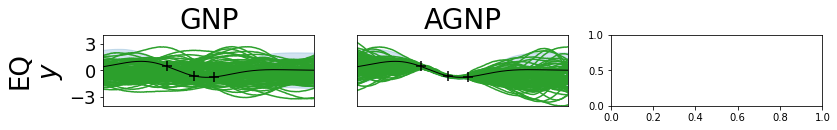

In [66]:
# models = [('GNP', StandardGNP, 'gnp-kvv-0'),
#           ('AGNP', StandardAGNP, 'agnp-kvv-0'),
#           ('ConvGNP', StandardConvGNP, 'convgnp-kvv-0'),
#           ('FullConvGNP', FullConvGNP, 'fcgnp-0'),
#           ('Oracle GP', None, None)]

# data_types = [('eq', eq_cov(lengthscale=1., coefficient=1., noise=1e-1), 'EQ'),
#               ('matern', mat_cov(lengthscale=1., coefficient=1., noise=1e-1), 'MAT'),
#               ('wp', wp_cov(period=0.25, lengthscale=1., coefficient=1., noise=1e-1), 'WP'),
#               ('nm', nm_cov(lengthscale1=1.0, lengthscale2=0.25, coefficient=1., noise=1e-1), 'NM')]

# levels = [np.linspace(-0.3, 1.2, 100),
#           np.linspace(-0.3, 2.0, 100),
#           np.linspace(-0.4, 1.5, 100),
#           np.linspace(-0.4, 3.0, 100)]
    
# plt.figure(figsize=(22, 1.5 * len(data_types)))

# for j, (data_type, generator) in enumerate(zip(data_types, generators)):

#     np.random.seed(1)
#     torch.manual_seed(1)
        
#     data = list(generator)[0]
#     a = np.arange(3)
#     idx = np.random.choice(np.arange(data['x'].shape[1]), size=(a.shape[0],), replace=False)
#     mask = np.ones(data['x'].shape[1], dtype=bool)
#     mask[idx] = False

#     x_context = data['x'][:, ~mask, :]
#     y_context = data['y'][:, ~mask, :]
#     x_target = data['x'][:, mask, :]
#     y_target = data['y'][:, mask, :]
    
#     x_plot = torch.linspace(xmin, xmax, 400)[None, :, None]
#     x_plot = x_plot.repeat(x_context.shape[0], 1, 1)
    
#     for i, model_type in enumerate(models):
        
#         plt.subplot(len(data_types), 5, j * len(models) + i + 1)
        
#         if i == len(models) - 1:
#             samples = sample_gp_post(x_data=x_context[0, :],
#                                      y_data=y_context[0, :],
#                                      x_pred=x_plot[0, :],
#                                      covariance=data_type[1],
#                                      num_samples=3)
#             for sample in samples:
#                 plt.plot(x_plot[0, :, 0], sample, color='tab:green', alpha=1.0)

#         else:
            
#             path = f'./models/{data_type[0]}-{model_type[2]}'

#             cov = KvvCov(num_basis_dim=num_basis_dim)
#             noise = AddHomoNoise()

#             if model_type[0] == 'FullConvGNP':
#                 model = model_type[1]()
#             else:
#                 model = model_type[1](input_dim=1, covariance=cov, add_noise=noise)

#             model.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['state_dict'])

#             model_output = model(x_context, y_context, x_plot)
#             mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]
#             cov = cov[0]

#             chol = np.linalg.cholesky(cov + 1e-4 * np.eye(cov.shape[0]))
#             samples = mean[0, :, :] + chol @ np.random.normal(size=(cov.shape[0], 100))

#             var = np.diag(cov)

#             plt.plot(x_plot[0, :, 0], samples, color='tab:green', alpha=1.)
            
#         plt.scatter(x_context[0, :, 0], y_context[0, :, 0], color='k', marker='+', s=100, zorder=4)
        
#         exact_mean, exact_var = exact_gp_post(x_data=x_context[0, :],
#                                               y_data=y_context[0, :],
#                                               x_pred=x_plot[0, :],
#                                               covariance=data_type[1])
        
#         plt.plot(x_plot[0, :, 0], exact_mean, color='k', linewidth=1., alpha=1)
        
#         plt.fill_between(x_plot[0, :, 0],
#                          exact_mean - 2 * exact_var ** 0.5,
#                          exact_mean + 2 * exact_var ** 0.5,
#                          color='tab:blue',
#                          zorder=1,
#                          alpha=0.2)
        
#         plt.xticks(np.linspace(-2, 2, 3), fontsize=16)
        
#         if i > 0:
#             plt.yticks([])
        
#         else:
#             plt.yticks(np.linspace(-3, 3, 3), fontsize=18)
#             plt.ylabel(f"{data_type[2]}" + "\n$y$", fontsize=26)
            
#         if j == len(data_types) - 1:
#             plt.xlabel('$x$', fontsize=26)
            
#         if j == 0:
#             plt.title(f'{model_type[0]}', fontsize=28)
            
#         if j < len(data_types) - 1:
#             plt.xticks([])
            
#         plt.xlim([-3, 3])
#         plt.ylim([-4, 4])
        
# plt.tight_layout()
# plt.savefig('plots/post-kvv.pdf')
# plt.show()

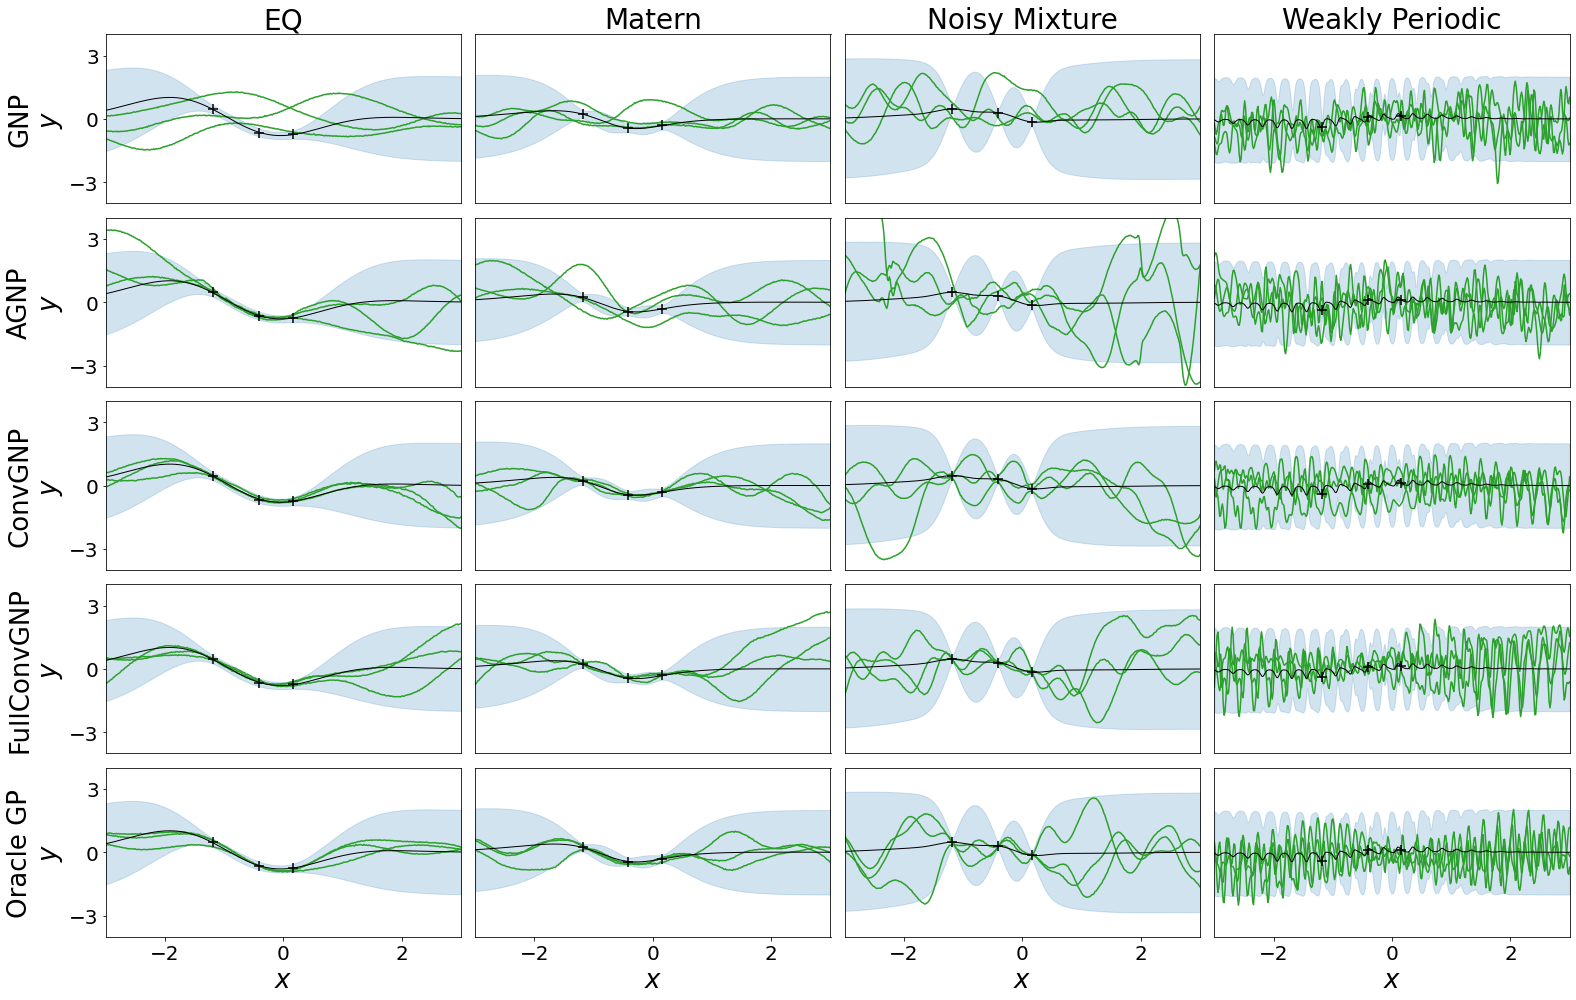

In [70]:
models = [('GNP', StandardGNP, 'gnp-kvv-0'),
          ('AGNP', StandardAGNP, 'agnp-kvv-0'),
          ('ConvGNP', StandardConvGNP, 'convgnp-kvv-0'),
          ('FullConvGNP', FullConvGNP, 'fcgnp-0'),
          ('Oracle GP', None, None)]

data_types = [('eq', eq_cov(lengthscale=1., coefficient=1., noise=1e-1), 'EQ'),
              ('matern', mat_cov(lengthscale=1., coefficient=1., noise=1e-1), 'Matern'),
              ('nm', nm_cov(lengthscale1=1.0, lengthscale2=0.25, coefficient=1., noise=1e-1), 'Noisy Mixture'),
              ('wp', wp_cov(period=0.25, lengthscale=1., coefficient=1., noise=1e-1), 'Weakly Periodic')]

levels = [np.linspace(-0.3, 1.2, 100),
          np.linspace(-0.3, 2.0, 100),
          np.linspace(-0.4, 1.5, 100),
          np.linspace(-0.4, 3.0, 100)]
    
plt.figure(figsize=(22, 3.5 * len(data_types)))

for j, (data_type, generator) in enumerate(zip(data_types, generators)):

    np.random.seed(1)
    torch.manual_seed(1)
        
    data = list(generator)[0]
    a = np.arange(3)
    idx = np.random.choice(np.arange(data['x'].shape[1]), size=(a.shape[0],), replace=False)
    mask = np.ones(data['x'].shape[1], dtype=bool)
    mask[idx] = False

    x_context = data['x'][:, ~mask, :]
    y_context = data['y'][:, ~mask, :]
    x_target = data['x'][:, mask, :]
    y_target = data['y'][:, mask, :]
    
    x_plot = torch.linspace(xmin, xmax, 400)[None, :, None]
    x_plot = x_plot.repeat(x_context.shape[0], 1, 1)
    
    for i, model_type in enumerate(models):
        
        plt.subplot(5, len(data_types), i * len(data_types) + j + 1)
        
        if i == len(models) - 1:
            samples = sample_gp_post(x_data=x_context[0, :],
                                     y_data=y_context[0, :],
                                     x_pred=x_plot[0, :],
                                     covariance=data_type[1],
                                     num_samples=3)
            for sample in samples:
                plt.plot(x_plot[0, :, 0], sample, color='tab:green', alpha=1.0)

        else:
            
            path = f'./models/{data_type[0]}-{model_type[2]}'

            cov = KvvCov(num_basis_dim=num_basis_dim)
            noise = AddHomoNoise()

            if model_type[0] == 'FullConvGNP':
                model = model_type[1]()
                
            elif model_type[0] == 'ConvGNP':
                model = model_type[1](input_dim=1, covariance=cov, add_noise=noise, num_noise_channels=0)
                    
            else:
                model = model_type[1](input_dim=1, covariance=cov, add_noise=noise)

            model.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['state_dict'])

            model_output = model(x_context, y_context, x_plot)
            mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]
            cov = cov[0]

            chol = np.linalg.cholesky(cov + 1e-4 * np.eye(cov.shape[0]))
            samples = mean[0, :, :] + chol @ np.random.normal(size=(cov.shape[0], 3))

            var = np.diag(cov)

            plt.plot(x_plot[0, :, 0], samples, color='tab:green', alpha=1.)
            
        plt.scatter(x_context[0, :, 0], y_context[0, :, 0], color='k', marker='+', s=100, zorder=4)
        
        exact_mean, exact_var = exact_gp_post(x_data=x_context[0, :],
                                              y_data=y_context[0, :],
                                              x_pred=x_plot[0, :],
                                              covariance=data_type[1])
        
        plt.plot(x_plot[0, :, 0], exact_mean, color='k', linewidth=1., alpha=1)
        
        plt.fill_between(x_plot[0, :, 0],
                         exact_mean - 2 * exact_var ** 0.5,
                         exact_mean + 2 * exact_var ** 0.5,
                         color='tab:blue',
                         zorder=1,
                         alpha=0.2)
        
        plt.xticks(np.linspace(-2, 2, 3), fontsize=20)
        
        if j > 0:
            plt.yticks([])
        
        else:
            plt.yticks(np.linspace(-3, 3, 3), fontsize=20)
            plt.ylabel(f"{model_type[0]}" + "\n$y$", fontsize=26)
            
        if i == len(models) - 1:
            plt.xlabel('$x$', fontsize=26)
            
        if i == 0:
            plt.title(f'{data_type[2]}', fontsize=28)
            
        if i < len(models) - 1:
            plt.xticks([])
            
        plt.xlim([-3, 3])
        plt.ylim([-4, 4])
        
plt.tight_layout()
plt.savefig('plots/post-kvv-transpose.pdf')
plt.show()

In [ ]:
# models = [('GNP', StandardGNP, 'gnp-innerprod-0'),
#           ('AGNP', StandardAGNP, 'agnp-innerprod-0'),
#           ('ConvGNP', StandardConvGNP, 'convgnp-innerprod-0'),
#           ('FullConvGNP', FullConvGNP, 'fcgnp-0')]

# data_types = [('eq', eq_cov(lengthscale=1., coefficient=1., noise=1e-1), 'EQ'),
#               ('matern', mat_cov(lengthscale=1., coefficient=1., noise=1e-1), 'MAT'),
#               ('wp', wp_cov(period=0.25, lengthscale=1., coefficient=1., noise=1e-1), 'WP'),
#               ('nm', nm_cov(lengthscale1=1.0, lengthscale2=0.25, coefficient=1., noise=1e-1), 'NM')]

# levels = [np.linspace(-0.3, 1.2, 100),
#           np.linspace(-0.3, 2.0, 100),
#           np.linspace(-0.4, 1.5, 100),
#           np.linspace(-0.4, 3.0, 100)]
    
# plt.figure(figsize=(22, 1.2 * len(data_types)))

# for j, (data_type, generator) in enumerate(zip(data_types, generators)):

#     np.random.seed(2)
#     torch.manual_seed(2)
        
#     data = list(generator)[0]
#     a = np.arange(4)
#     idx = np.random.choice(np.arange(data['x'].shape[1]), size=(a.shape[0],), replace=False)
#     mask = np.ones(data['x'].shape[1], dtype=bool)
#     mask[idx] = False

#     x_context = data['x'][:, ~mask, :]
#     y_context = data['y'][:, ~mask, :]
#     x_target = data['x'][:, mask, :]
#     y_target = data['y'][:, mask, :]
    
#     x_plot = torch.linspace(xmin, xmax, 200)[None, :, None]
#     x_plot = x_plot.repeat(x_context.shape[0], 1, 1)
    
#     for i, model_type in enumerate(models):
        
#         plt.subplot(len(data_types), 4, j * len(models) + i + 1)

#         path = f'./models/{data_type[0]}-{model_type[2]}'

#         cov = InnerProdCov(num_basis_dim=num_basis_dim)
#         noise = AddHomoNoise()

#         if model_type[0] == 'FullConvGNP':
#             model = model_type[1]()
#         else:
#             model = model_type[1](input_dim=1, covariance=cov, add_noise=noise)
            
#         model.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['state_dict'])

#         model_output = model(x_context, y_context, x_plot)
#         mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]
#         cov = cov[0]
        
#         chol = np.linalg.cholesky(cov + 1e-4 * np.eye(cov.shape[0]))
#         samples = mean[0, :, :] + chol @ np.random.normal(size=(cov.shape[0], 100))
        
#         var = np.diag(cov)

#         plt.plot(x_plot[0, :, 0], mean[0, :, 0], color='green', alpha=0.5)

#         plt.plot(x_plot[0, :, 0], samples, color='green', alpha=0.1)
        
#         plt.scatter(x_context[0, :, 0], y_context[0, :, 0], color='k', marker='+', s=100)
        
#         exact_mean, exact_var = exact_gp_post(x_data=x_context[0, :],
#                                               y_data=y_context[0, :],
#                                               x_pred=x_plot[0, :],
#                                               covariance=data_type[1])
        
#         plt.plot(x_plot[0, :, 0], exact_mean, color='k', linewidth=1., alpha=1)
#         plt.plot(x_plot[0, :, 0], exact_mean - 2 * exact_var ** 0.5, '--', color='k', linewidth=1., alpha=1)
#         plt.plot(x_plot[0, :, 0], exact_mean + 2 * exact_var ** 0.5, '--', color='k', linewidth=1., alpha=1)
        
#         plt.xticks(np.linspace(-2, 2, 3), fontsize=16)
        
#         if i > 0:
#             plt.yticks([])
        
#         else:
#             plt.yticks(np.linspace(-3, 3, 3), fontsize=18)
#             plt.ylabel(f"{data_type[2]}" + "\n$y$", fontsize=24)
            
#         if j == len(data_types) - 1:
#             plt.xlabel('$x$', fontsize=24)
            
#         if j == 0:
#             plt.title(f'{model_type[0]}', fontsize=24)
            
#         if j < len(data_types) - 1:
#             plt.xticks([])
            
#         plt.xlim([-3, 3])
#         plt.ylim([-4, 4])
        
# plt.tight_layout()
# plt.savefig('plots/post-inner.pdf')
# plt.show()